Импорт необходимых библиотек

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

Задание 1: Детекция аномалий в данных кредитного скоринга  
Используйте набор данных кредитного скоринга (https://www.kaggle.com/mlg-ulb/creditcardfraud) и определите аномалии в данных, используя Z-score или IQR. 

In [36]:
# Загрузка данных
data_1 = pd.read_csv('Data/creditcard.csv')

# Удаление ненужных столбцов
data_1_cleaned = data_1.drop(columns=['Time', 'Amount', 'Class'])

# Z-оценка помогает выявлять выбросы, сравнивая значение признака 
# с его средним значением и стандартным отклонением. Если Z-оценка 
# значительно превышает порог, значение считается аномалией.
# Функция для детекции выбросов на основе Z-оценки
def detect_outliers_zscore(data, threshold=3): # порог для Z-оценки=3, значения выше - аномалия
    z_scores = np.abs(stats.zscore(data))
    outliers = (z_scores > threshold)
    return np.where(outliers)

# Применим Z-score
outliers_z = detect_outliers_zscore(data_1_cleaned)

# Межквартильный размах (IQR) — это метод, который использует расстояние 
# между первым и третьим квартилями для выявления выбросов. Значения, 
# которые значительно выходят за пределы IQR, считаются аномалиями.
# Функция для детекции выбросов на основе IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# Применим IQR
outliers_iqr = detect_outliers_iqr(data_1_cleaned)

# Подсчет числа аномалий на основе Z-оценки
def count_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = np.where(z_scores > threshold)
    unique_outliers = np.unique(outliers[0])  # Получаем индексы строк с выбросами
    return len(unique_outliers)

# Подсчет числа аномалий на основе IQR
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    
    # Считаем строки, где хотя бы одно значение является выбросом
    outlier_rows = outliers.any(axis=1)
    return outlier_rows.sum()

# Подсчитаем количество аномалий
zscore_outliers_count = count_outliers_zscore(data_1_cleaned)
print(f"Число аномалий по Z-оценке: {zscore_outliers_count}")

# Подсчитаем количество аномалий
iqr_outliers_count = count_outliers_iqr(data_1_cleaned)
print(f"Число аномалий по IQR: {iqr_outliers_count}")

Число аномалий по Z-оценке: 36636
Число аномалий по IQR: 128657


Задание 2: Обнаружение аномалий в данных о температуре  
В наборе данных о температуре в различных городах (https://www.kaggle.com/smid80/weatherww2) обнаружьте аномальные значения температуры.


In [37]:
# Загрузка данных
data_2 = pd.read_csv('Data/Summary of Weather.csv')

# Извлекаем нужные столбцы для анализа аномалий
data_2_cleaned = data_2[['MaxTemp', 'MinTemp', 'MeanTemp']]

# Заменим возможные пустые значения на NaN и удалим строки с пропусками
data_2_cleaned = data_2_cleaned.replace('T', np.nan).astype(float)
data_2_cleaned = data_2_cleaned.dropna()

# Применим Z-score
outliers_z = detect_outliers_zscore(data_2_cleaned)

# Применим IQR
outliers_iqr = detect_outliers_iqr(data_2_cleaned)

# Подсчитаем количество аномалий
zscore_outliers_count = count_outliers_zscore(data_2_cleaned)
print(f"Число аномалий по Z-оценке: {zscore_outliers_count}")

# Подсчитаем количество аномалий
iqr_outliers_count = count_outliers_iqr(data_2_cleaned)
print(f"Число аномалий по IQR: {iqr_outliers_count}")

Число аномалий по Z-оценке: 2776
Число аномалий по IQR: 14795


C:\Users\vladi\AppData\Local\Temp\ipykernel_20968\1756415729.py:2: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2 = pd.read_csv('Data/Summary of Weather.csv')


Задание 3: Прогнозирование пропущенных значений в данных о болезни диабета.  
В данных о диабете Pima Indians (https://www.kaggle.com/uciml/pima-indians-diabetes-database) есть пропущенные значения. Воспользуйтесь методами регрессии или классификации для предсказания пропущенных значений.

In [38]:
# Загрузка данных
data_3 = pd.read_csv('Data/diabetes.csv')

# Определим столбцы, где значения 0 можно считать пропущенными
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Заменим нули на NaN для дальнейшего прогнозирования
data_3[columns_with_zeros] = data_3[columns_with_zeros].replace(0, np.nan)

# K-ближайших соседей (KNN): Метод может использовать 
# средние значения соседей для заполнения пропусков.

# Создаем экземпляр KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Применяем KNN для заполнения пропусков
data_imputed = pd.DataFrame(imputer.fit_transform(data_3), columns=data_3.columns)

# Разделение данных на обучающую и тестовую выборки
X = data_imputed.drop('Outcome', axis=1)
y = data_imputed['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Чем меньше MSE, тем точнее модель. Если MSE равно 0, 
# это означает, что модель идеально предсказала все значения.

Mean Squared Error: 0.1651525519910768


Задание 4: Обработка пропущенных значений  
Используя набор данных о пассажирах Титаника из библиотеки Seaborn (sns.load_dataset('titanic')), необходимо найти и обработать все пропущенные значения. Можно использовать различные методы (например, удаление, заполнение средним значением или медианой). Сравнить результаты.

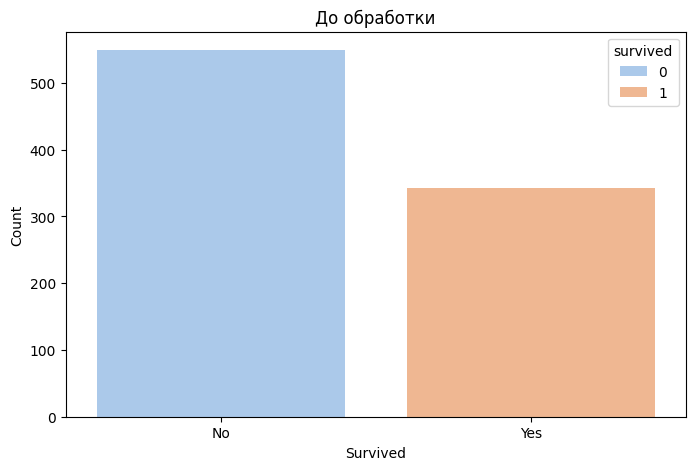

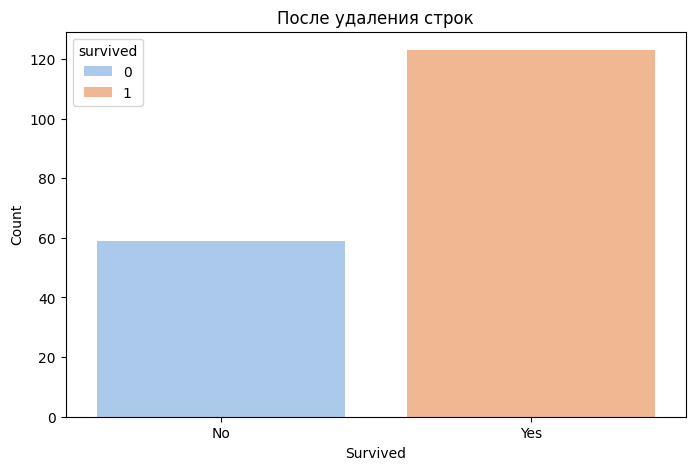

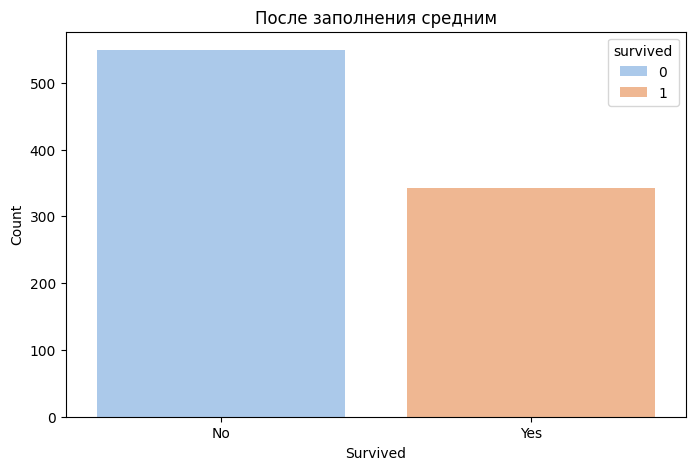

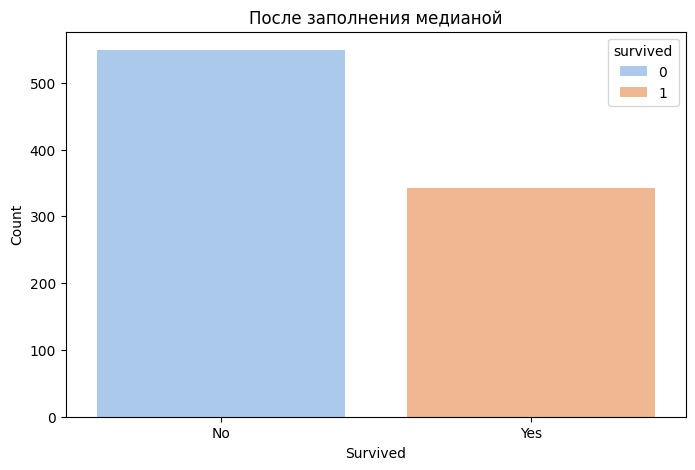

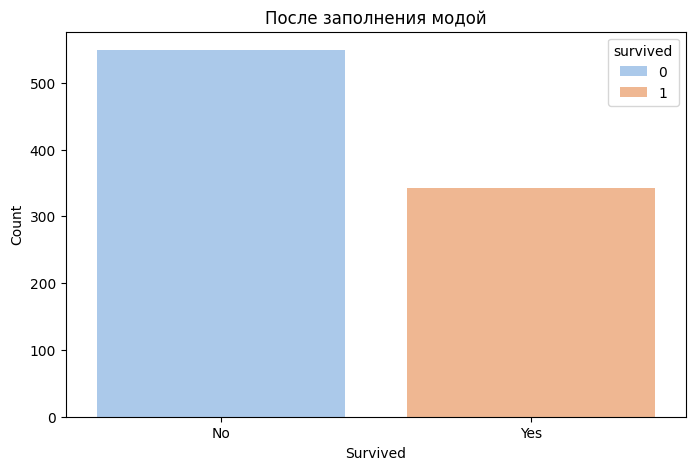

In [39]:
# Загрузка данных
titanic = sb.load_dataset('titanic')

# Удаление строк с пропущенными значениями
titanic_dropped = titanic.dropna()

# Заполнение пропущенных значений возрастов средним значением
age_mean = titanic['age'].mean()  
titanic_mean_filled = titanic.copy()
titanic_mean_filled['age'] = titanic_mean_filled['age'].fillna(age_mean)

# Заполнение пропущенных значений возрастов медианой
age_median = titanic['age'].median()  # Медиана для возраста
titanic_median_filled = titanic.copy()
titanic_median_filled['age'] = titanic_median_filled['age'].fillna(age_median)

# Заполнение пропущенных значений в 'embarked' наиболее частым значением
titanic_mode_filled = titanic.copy()
titanic_mode_filled['embarked'] = titanic_mode_filled['embarked'].fillna(titanic['embarked'].mode()[0])

# Визуализация до обработки
def plot_survival(data, title):
    plt.figure(figsize=(8, 5))
    sb.countplot(data=data, x='survived', hue='survived', palette='pastel')
    plt.title(title)
    plt.xlabel('Survived')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.show()

# Визуализация до обработки
plot_survival(titanic, 'До обработки')

# Визуализация после удаления строк
plot_survival(titanic_dropped, 'После удаления строк')

# Визуализация после заполнения средним значением
plot_survival(titanic_mean_filled, 'После заполнения средним')

# Визуализация после заполнения медианой
plot_survival(titanic_median_filled, 'После заполнения медианой')

# Визуализация после заполнения модой
plot_survival(titanic_mode_filled, 'После заполнения модой')

Задание 5: Нормализация и стандартизация признаков датасета "Red Wine Quality"  
Для набора данных о качестве красного вина (https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) примените различные методы нормализации и стандартизации к признакам, сравните результаты их применения.

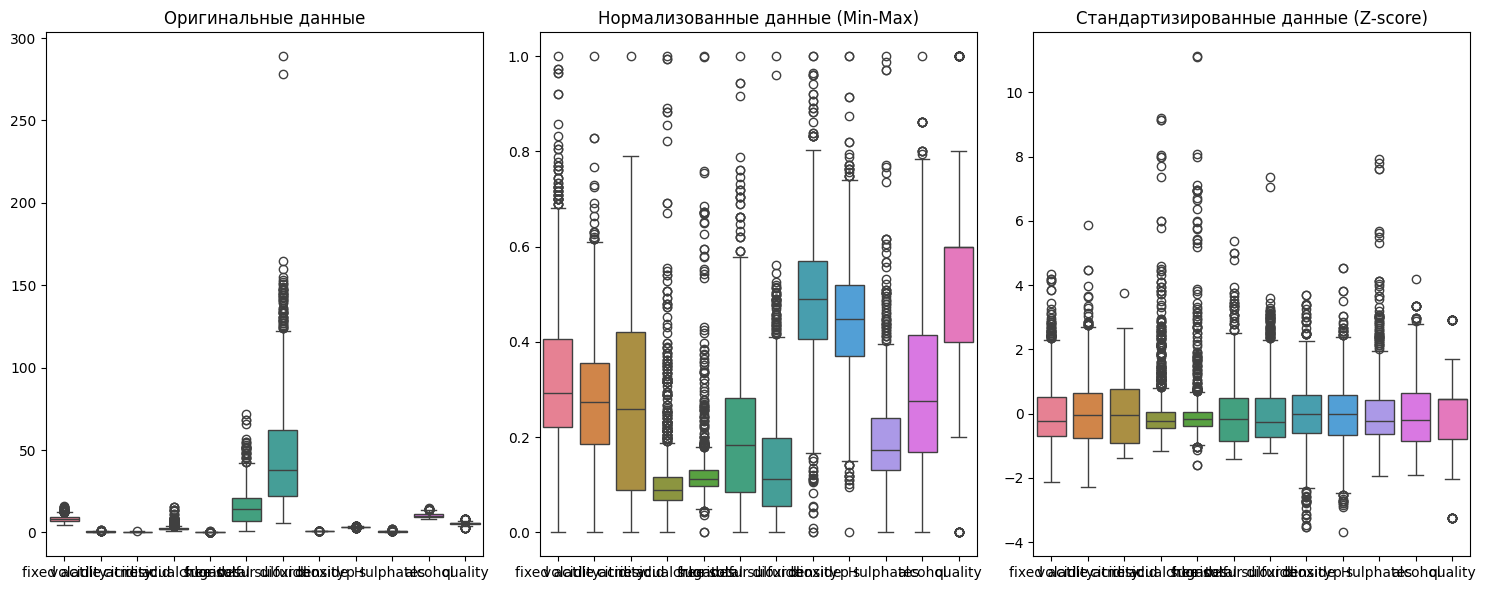

In [40]:
# Загрузка данных
data_5 = pd.read_csv('Data/winequality-red.csv')

# Определение признаков для нормализации и стандартизации
features = data_5.select_dtypes(include=['float64', 'int64']).columns

# Применение нормализации (Min-Max) (приводит значения к диапазону [0;1])
min_max_scaler = MinMaxScaler()
data_normalized = data_5.copy()
data_normalized[features] = min_max_scaler.fit_transform(data_5[features])

# Применение стандартизации (Z-score) 
# (приводит значения к стандартному нормальному распределению со средним=0, стандартным отклонением=1)
standard_scaler = StandardScaler()
data_standardized = data_5.copy()
data_standardized[features] = standard_scaler.fit_transform(data_5[features])

# Визуализация результатов нормализации
plt.figure(figsize=(15, 6))

# Оригинальные данные
plt.subplot(1, 3, 1)
sb.boxplot(data=data_5[features])
plt.title('Оригинальные данные')

# Нормализованные данные
plt.subplot(1, 3, 2)
sb.boxplot(data=data_normalized[features])
plt.title('Нормализованные данные (Min-Max)')

# Стандартизированные данные
plt.subplot(1, 3, 3)
sb.boxplot(data=data_standardized[features])
plt.title('Стандартизированные данные (Z-score)')

plt.tight_layout()
plt.show()

Задание 6: Применение описательной статистики и корреляционного анализа для датасета "House Prices"  
На данных о ценах на жилье (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) рассчитайте основные метрики описательной статистики для числовых переменных и рассчитайте корреляции между переменными. Визуализируйте корреляции с помощью тепловых карт и обратите внимание на сильные корреляции.

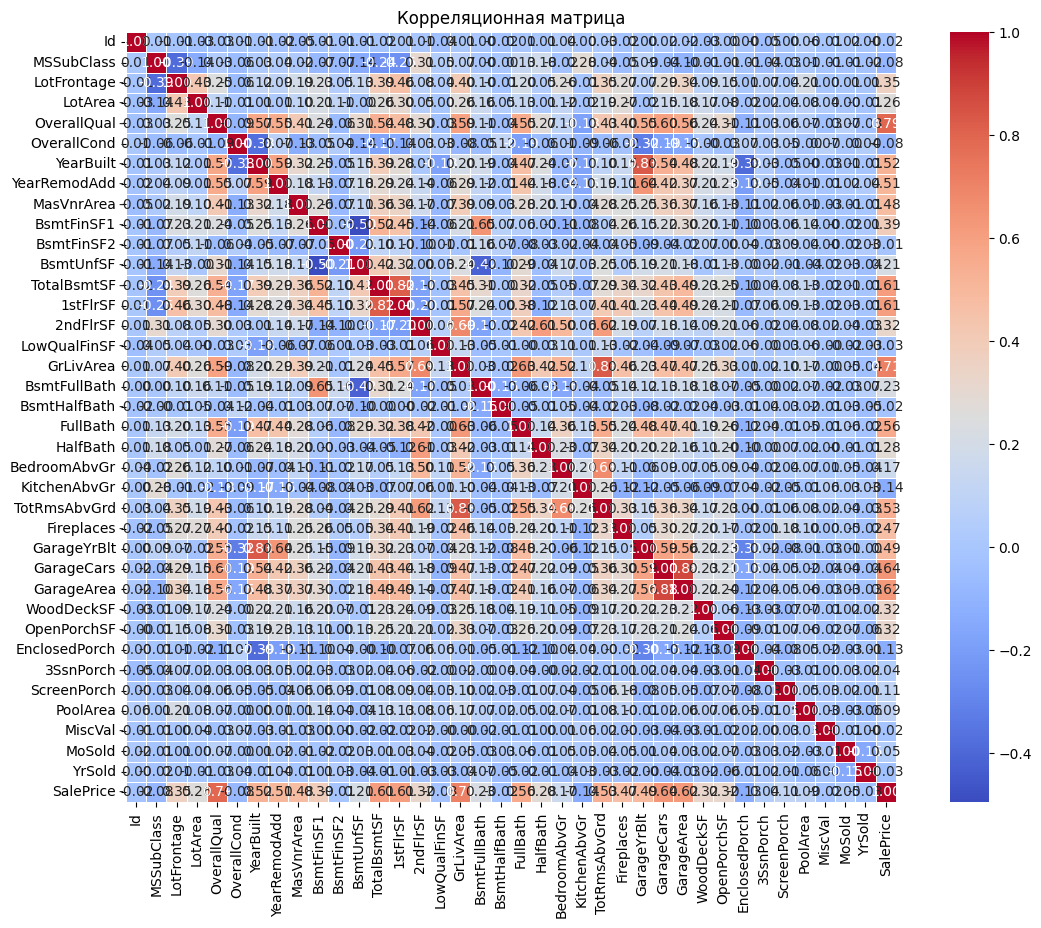

Сильные корреляции:
                Id  MSSubClass  LotFrontage  LotArea  OverallQual  \
Id             1.0         NaN          NaN      NaN          NaN   
MSSubClass     NaN         1.0          NaN      NaN          NaN   
LotFrontage    NaN         NaN          1.0      NaN          NaN   
LotArea        NaN         NaN          NaN      1.0          NaN   
OverallQual    NaN         NaN          NaN      NaN     1.000000   
OverallCond    NaN         NaN          NaN      NaN          NaN   
YearBuilt      NaN         NaN          NaN      NaN     0.572323   
YearRemodAdd   NaN         NaN          NaN      NaN     0.550684   
MasVnrArea     NaN         NaN          NaN      NaN          NaN   
BsmtFinSF1     NaN         NaN          NaN      NaN          NaN   
BsmtFinSF2     NaN         NaN          NaN      NaN          NaN   
BsmtUnfSF      NaN         NaN          NaN      NaN          NaN   
TotalBsmtSF    NaN         NaN          NaN      NaN     0.537808   
1stFlrSF      

In [41]:
# Загрузка данных
data_6 = pd.read_csv('Data/train.csv')

# Выбор числовых переменных
numerical_features = data_6.select_dtypes(include=['float64', 'int64']).columns

# Расчет корреляций
correlation_matrix = data_6[numerical_features].corr()

# Визуализация корреляций
plt.figure(figsize=(14, 10))
sb.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
plt.title('Корреляционная матрица')
plt.show()

# Выделение сильных корреляций
threshold = 0.5  # Порог для сильной корреляции
strong_correlations = correlation_matrix[correlation_matrix.abs() > threshold]
print("Сильные корреляции:")
print(strong_correlations)

Задание 7: Обработка текстовых данных в датасете "Twitter Airline Sentiment"  
Набор данных "Twitter Airline Sentiment" на Kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment) содержит реальные твиты о различных авиакомпаниях. Примените техники предобработки текста, вроде удаления стоп-слов, стемминга, лемматизации и векторизации для подготовки данных к анализу.

In [53]:
# Загрузка данных
data_7 = pd.read_csv('Data/Tweets.csv')

# Загрузка списка стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Функция для удаления стоп-слов
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

# Применение функции к колонке 'text'
data_7['cleaned_text'] = data_7['text'].apply(remove_stopwords)

# Загрузка стеммера
stemmer = PorterStemmer()

# Функция для стемминга
def stem_words(text):
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

# Применение стемминга
data_7['stemmed_text'] = data_7['cleaned_text'].apply(stem_words)

# Загрузка лемматизатора
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации
def lemmatize_words(text):
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# Применение лемматизации
data_7['lemmatized_text'] = data_7['cleaned_text'].apply(lemmatize_words)

# Векторизация текста с помощью CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_7['lemmatized_text'])

# Преобразование в DataFrame для удобства
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Просмотр векторизованных данных
print(X_df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   00  000  000114  000419  000ft  000lbs  0011  0016  00a  00am  ...  \
0   0    0       0       0      0       0     0     0    0     0  ...   
1   0    0       0       0      0       0     0     0    0     0  ...   
2   0    0       0       0      0       0     0     0    0     0  ...   
3   0    0       0       0      0       0     0     0    0     0  ...   
4   0    0       0       0      0       0     0     0    0     0  ...   

   zrh_airport  zsdgzydnde  zsuztnaijq  ztrdwv0n4l  zukes  zurich  zv2pt6trk9  \
0            0           0           0           0      0       0           0   
1            0           0           0           0      0       0           0   
2            0           0           0           0      0       0           0   
3            0           0           0           0      0       0           0   
4            0           0           0           0      0       0           0   

   zv6cfpohl5  zvfmxnuelj  zzps5ywve2  
0           0           0         